In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import savgol_filter
from scipy import stats

plt.style.use('seaborn')
%matplotlib inline
sns.set()

In [2]:
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal

def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal

def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves

def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw

def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal

def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210524_green_tests/blah_two_spects_210523.h5 session005/cal001


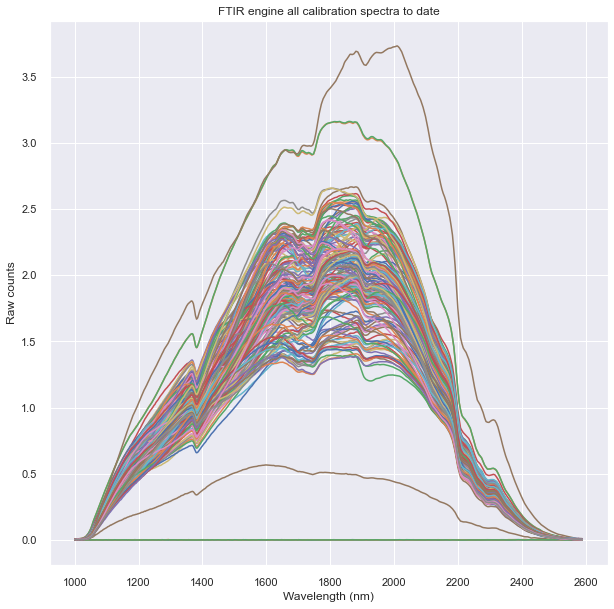

In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
df = pd.read_csv('data/All_green_files_210604.csv')
vis_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        vis_cals.append((file_name, date, calibration[2:12], calibration[-6:]))

vis_cals_df = pd.DataFrame(data=vis_cals, columns=['file_name', 'date', 'session', 'calibration'])

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("FTIR engine all calibration spectra to date")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in vis_cals_df.index.values:
    file_name = vis_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = vis_cals_df['session'][index] + "/" + vis_cals_df['calibration'][index]
    try:
        ftir_waves = get_ftir_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
        ax.plot(ftir_waves, ftir_cal_spectrum)
    except:
        print(file, cal_path)
plt.show()
plt.close()

210524_green_tests/blah_two_spects_210523.h5 session005/cal001


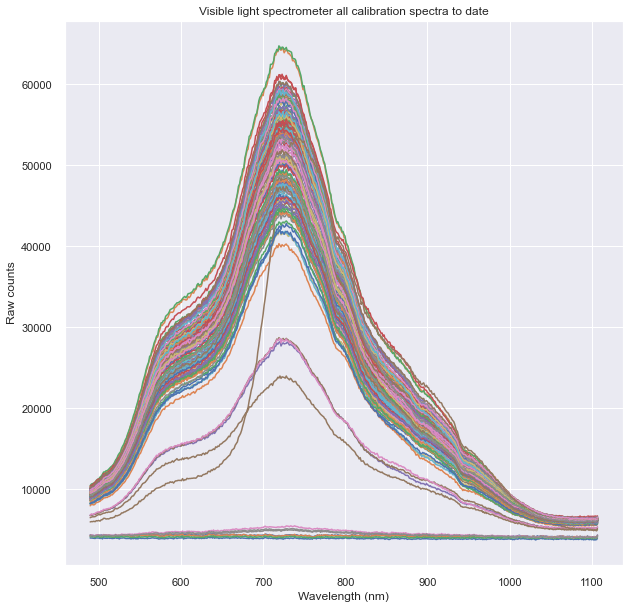

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Visible light spectrometer all calibration spectra to date")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in vis_cals_df.index.values:
    file_name = vis_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = vis_cals_df['session'][index] + "/" + vis_cals_df['calibration'][index]
    try:
        vis_waves = get_visible_wavelength_vector(file, cal_path)
        vis_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
        ax.plot(vis_waves, vis_cal_spectrum)
    except:
        print(file_name, cal_path)
plt.show()
plt.close()

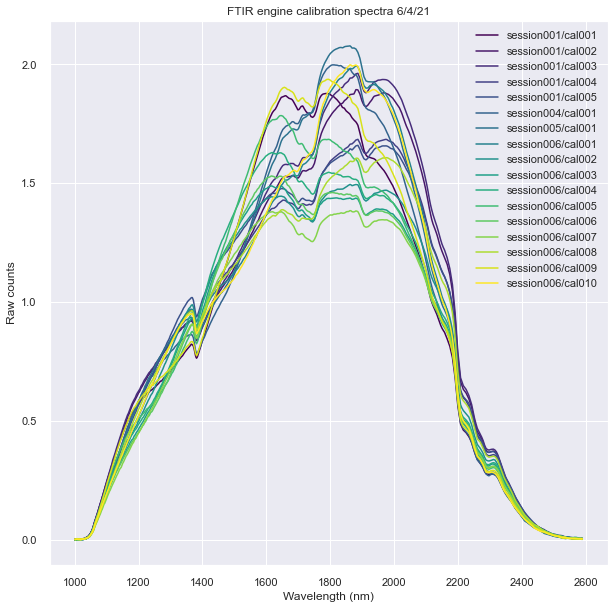

In [5]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '6/4/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()


fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f"FTIR engine calibration spectra {date}")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
max_val = one_date_df.index.values.max()
min_val = one_date_df.index.values.min()
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    color = plt.cm.viridis((index - min_val)/(max_val - min_val))
    try:
        ftir_waves = get_ftir_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
        ax.plot(ftir_waves, ftir_cal_spectrum, color=color, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

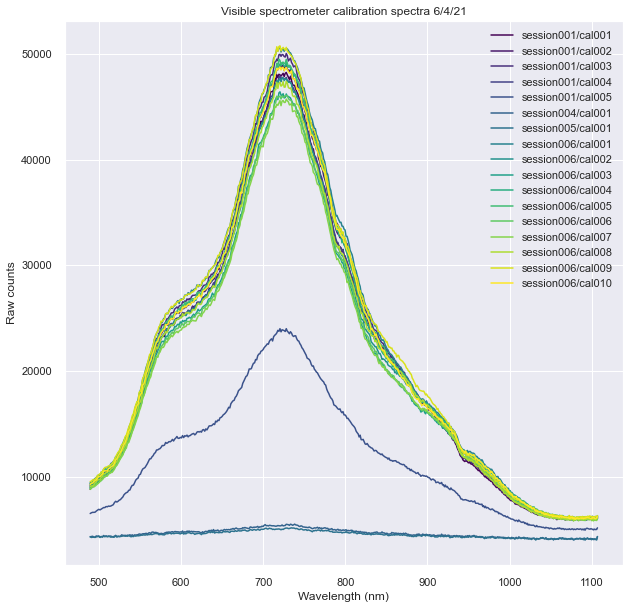

In [6]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '6/4/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f"Visible spectrometer calibration spectra {date}")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")

max_val = one_date_df.index.values.max()
min_val = one_date_df.index.values.min()
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    color = plt.cm.viridis((index - min_val)/(max_val - min_val))
    try:
        ftir_waves = get_visible_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
        ax.plot(ftir_waves, ftir_cal_spectrum, color=color, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

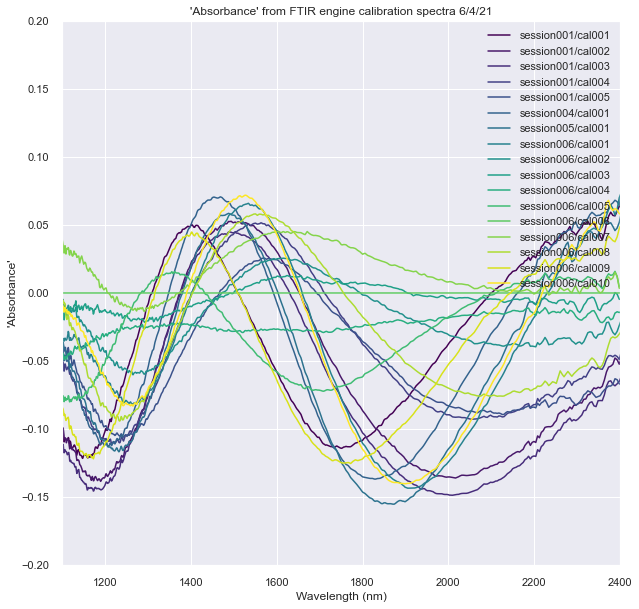

In [7]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '6/4/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()
file_name = one_date_df.iat[0, 0]
file = path_name + file_name
reference_spectrum_path = 'session006/cal006'
reference_spectrum = get_ftir_white_calibration_curve(file, reference_spectrum_path)
dark_spectrum = get_ftir_dark_calibration_curve(file, reference_spectrum_path)

max_val = one_date_df.index.values.max()
min_val = one_date_df.index.values.min()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f"'Absorbance' from FTIR engine calibration spectra {date}")
ax.set_ylim(-0.2, 0.2)
ax.set_xlim(1100, 2400)
ax.set_ylabel("'Absorbance'")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    color = plt.cm.viridis((index - min_val)/(max_val - min_val))
    try:
        ftir_waves = get_ftir_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
        cal_absorbance = calculate_absorbance_from_raw(ftir_cal_spectrum, reference_spectrum, dark_spectrum)
        ax.plot(ftir_waves, cal_absorbance, color=color, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

<ipython-input-2-0860ab87f030>:42: RuntimeWarning: invalid value encountered in log10
  absorbance = np.log10(inverse_reflectance.astype(np.float64))
<ipython-input-2-0860ab87f030>:41: RuntimeWarning: divide by zero encountered in true_divide
  inverse_reflectance = 1/reflectance
<ipython-input-2-0860ab87f030>:42: RuntimeWarning: invalid value encountered in log10
  absorbance = np.log10(inverse_reflectance.astype(np.float64))


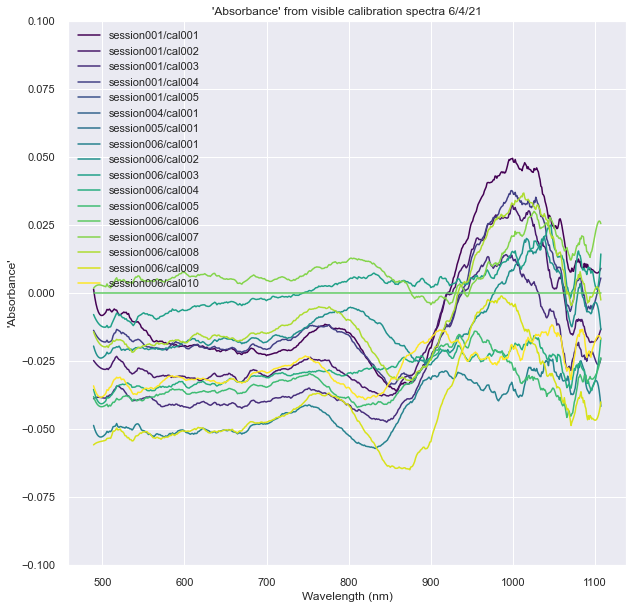

In [8]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '6/4/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()
file_name = one_date_df.iat[0, 0]
file = path_name + file_name
reference_spectrum_path = 'session006/cal006'
reference_spectrum = get_visible_white_calibration_curve(file, reference_spectrum_path)
dark_spectrum = get_visible_dark_calibration_curve(file, reference_spectrum_path)

max_val = one_date_df.index.values.max()
min_val = one_date_df.index.values.min()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f"'Absorbance' from visible calibration spectra {date}")
ax.set_ylim(-0.1, 0.1)
# ax.set_xlim(1100, 2400)
ax.set_ylabel("'Absorbance'")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    color = plt.cm.viridis((index - min_val)/(max_val - min_val))
    try:
        ftir_waves = get_visible_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
        cal_absorbance = calculate_absorbance_from_raw(ftir_cal_spectrum, reference_spectrum, dark_spectrum)
        ax.plot(ftir_waves, savgol_filter(cal_absorbance, 21, 3), color=color, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

Exception thrown for  5/24/21 session005/cal001


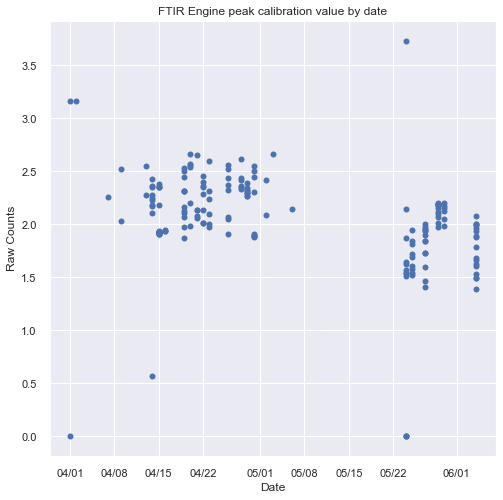

In [10]:
df = pd.read_csv('data/All_green_files_210604.csv')
vis_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        vis_cals.append((file_name, date, calibration[2:12], calibration[-6:]))

vis_cals_df = pd.DataFrame(data=vis_cals, columns=['file_name', 'date', 'session', 'calibration'])
# print(vis_cals_df)

path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
dates = []
date_strs = []
white_values = []
for i in range(vis_cals_df.shape[0]):
    entire_path = path_name + vis_cals_df.iat[i, 0]
    cal_path = vis_cals_df.iat[i, 2] + "/" + vis_cals_df.iat[i, 3]
    date_str = vis_cals_df.iat[i, 1]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    try:
        with h5py.File(entire_path, 'r') as h5_file: 
        
            spectrum = h5_file[cal_path].attrs['white_spectrum2'][:]
            waves = h5_file[cal_path].attrs['spec2_wavelengths_vector'][:]
    except:
        print("Exception thrown for ", date_str, cal_path)
                
    white_value = spectrum.max()
    dates.append(date)
    date_strs.append(date_str)
    white_values.append(white_value)


fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("FTIR Engine peak calibration value by date")
ax.set_xlabel("Date")
ax.set_ylabel("Raw Counts")
# ax.set_ylim(10000, 20000)
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)


ax.plot_date(dates, white_values, 'bo')

plt.show()
plt.close()

Exception thrown for  5/24/21 session005/cal001


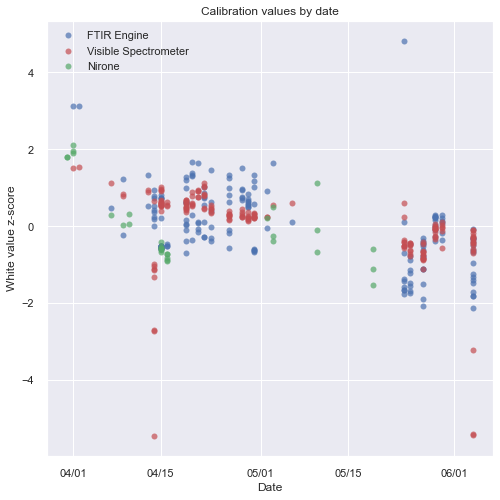

In [11]:
def calculate_normalized_white_values(white_values):
    min_white_value = min(white_values)
    max_white_value = max(white_values)
    normalized_white_values = []
    for i in range(len(white_values)):
        normalized_white_value = (white_values[i] - min_white_value)/(max_white_value - min_white_value)
        normalized_white_values.append(normalized_white_value)
    return normalized_white_values
        

#ftir spectra lower than threshold are bad outliers
spectrometer_bad_max_threshold = 1.0
#nirone spectra lower than threshold are bad outliers
nirone_bad_max_threshold = 2500
df = pd.read_csv('data/All_green_files_210604.csv')
nirone_df = pd.read_csv('data/All_nirone_files_210527.csv')


# get visible spectrometer and ftir engine calibration information
vis_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        vis_cals.append((file_name, date, calibration[2:12], calibration[-6:]))
vis_cals_df = pd.DataFrame(data=vis_cals, columns=['file_name', 'date', 'session', 'calibration'])

# get nirone calibration information
nirone_cals = []
for index in nirone_df.index.values:
    file_name = nirone_df['file_name'][index]
    file = path_name + file_name
    date = nirone_df['date'][index]
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        nirone_cals.append((file_name, date, calibration[2:12], calibration[-6:]))
nirone_cals_df = pd.DataFrame(data=nirone_cals, columns=['file_name', 'date', 'session', 'calibration'])

# get visible spectrometer and ftir engine calibrations
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
ftir_dates = []
ftir_date_strs = []
ftir_white_values = []
vis_white_values = []
for i in range(vis_cals_df.shape[0]):
    entire_path = path_name + vis_cals_df.iat[i, 0]
    cal_path = vis_cals_df.iat[i, 2] + "/" + vis_cals_df.iat[i, 3]
    date_str = vis_cals_df.iat[i, 1]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    try:
        with h5py.File(entire_path, 'r') as h5_file:
            vis_spectrum = h5_file[cal_path].attrs['white_spectrum'][:]      
            ftir_spectrum = h5_file[cal_path].attrs['white_spectrum2'][:]
    except:
        print("Exception thrown for ", date_str, cal_path)
    # calculate ftir engine and visible spectrometer maximum white values            
    ftir_white_value = ftir_spectrum.max()
    vis_white_value = vis_spectrum.max()
    if ftir_white_value > spectrometer_bad_max_threshold:
        ftir_dates.append(date)
        ftir_date_strs.append(date_str)
        ftir_white_values.append(ftir_white_value)
        vis_white_values.append(vis_white_value)
    else:
        pass
    
# get nirone calibrations
nirone_dates = []
nirone_date_strs = []
nirone_white_values = []
for i in range(nirone_cals_df.shape[0]):
    entire_path = path_name + nirone_cals_df.iat[i, 0]
    cal_path = nirone_cals_df.iat[i, 2] + "/" + nirone_cals_df.iat[i, 3]
    date_str = nirone_cals_df.iat[i, 1]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()    
    try:
        with h5py.File(entire_path, 'r') as h5_file:
            nirone_spectrum = h5_file[cal_path].attrs['white_spectrum'][:]
            waves = h5_file[cal_path].attrs['spec1_wavelengths_vector'][:]
            # print(waves)
        
    except:
        print("Exception thrown for ", date_str, cal_path)
        
    index_value = np.where(waves == 1750.0)
    white_value = nirone_spectrum[index_value][0]
    nirone_white_value = nirone_spectrum.max()
    if nirone_white_value > nirone_bad_max_threshold:
        nirone_dates.append(date)
        nirone_date_strs.append(date_str)
        nirone_white_values.append(nirone_white_value)
    else:
        pass
    

# calculate the normalized values
# ftir_normalized_values = calculate_normalized_white_values(ftir_white_values)
# vis_normalized_values = calculate_normalized_white_values(vis_white_values)
# nirone_normalized_values = calculate_normalized_white_values(nirone_white_values)

ftir_normalized_values = stats.zscore(ftir_white_values)
vis_normalized_values = stats.zscore(vis_white_values)
nirone_normalized_values = stats.zscore(nirone_white_values)

# plot the figure
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Calibration values by date")
ax.set_xlabel("Date")
ax.set_ylabel("White value z-score")
# ax.set_ylim(10000, 20000)
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
ax.plot_date(ftir_dates, ftir_normalized_values, 'bo', label='FTIR Engine', alpha=0.7)
ax.plot_date(ftir_dates, vis_normalized_values, 'ro', label = 'Visible Spectrometer', alpha=0.7)
ax.plot_date(nirone_dates, nirone_normalized_values, 'go', label='Nirone', alpha=0.7)
ax.legend()
plt.show()
plt.close()

In [ ]:
df = pd.read_csv('data/All_green_files_210604.csv')
vis_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        vis_cals.append((file_name, date, calibration[2:12], calibration[-6:]))

vis_cals_df = pd.DataFrame(data=vis_cals, columns=['file_name', 'date', 'session', 'calibration'])
# print(vis_cals_df)

path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '6/4/21'

for i in range(vis_cals_df.shape[0]):
    entire_path = path_name + vis_cals_df.iat[i, 0]
    cal_path = vis_cals_df.iat[i, 2] + "/" + vis_cals_df.iat[i, 3]
    
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    try:
        with h5py.File(entire_path, 'r') as h5_file: 
        
            spectrum = h5_file[cal_path].attrs['white_spectrum'][:]
            waves = h5_file[cal_path].attrs['spec1_wavelengths_vector'][:]
            time = h5_file[cal_path].attrs['']
    except:
        print("Exception thrown for ", date_str, cal_path)
                
    white_value = spectrum.max()
    dates.append(date)
    date_strs.append(date_str)
    white_values.append(white_value)


fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Visible light spectrometer peak calibration value by date")
ax.set_xlabel("Date")
ax.set_ylabel("Raw Counts")
# ax.set_ylim(10000, 20000)
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)


ax.plot_date(dates, white_values, 'bo')

plt.show()
plt.close()

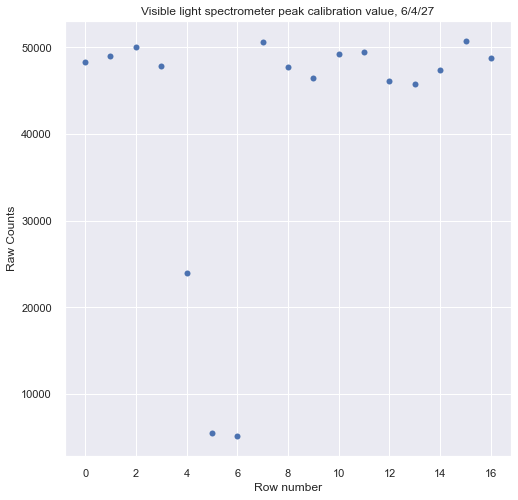

In [20]:
df = pd.read_csv('data/All_green_files_210604.csv')
vis_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        vis_cals.append((file_name, date, calibration[2:12], calibration[-6:]))

vis_cals_df = pd.DataFrame(data=vis_cals, columns=['file_name', 'date', 'session', 'calibration'])
today_df = vis_cals_df.loc[vis_cals_df['date'] == '6/4/21']

i_s = []
date_strs = []
white_values = []
for i in range(today_df.shape[0]):
    i_s.append(i)
    entire_path = path_name + today_df.iat[i, 0]
    cal_path = today_df.iat[i, 2] + "/" + today_df.iat[i, 3]
    date_str = vis_cals_df.iat[i, 1]
    
    try:
        with h5py.File(entire_path, 'r') as h5_file:
            spectrum = h5_file[cal_path].attrs['white_spectrum'][:]
            waves = h5_file[cal_path].attrs['spec1_wavelengths_vector'][:]
    except:
        print("Exception thrown for ", date_str, cal_path)
                
    white_value = spectrum.max()    
    white_values.append(white_value)
    
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Visible light spectrometer peak calibration value, 6/4/27")
ax.set_xlabel("Row number")
ax.set_ylabel("Raw Counts")
# ax.set_ylim(10000, 20000)
ax.plot(i_s, white_values, 'bo')

plt.show()
plt.close()

In [17]:
with h5py.File(file, 'r') as h5_file:
    print(h5_file[cal_path].attrs.keys())

<KeysViewHDF5 ['calibration_start_time', 'dark_spectrum', 'dark_spectrum2', 'ftir_amplitude', 'ftir_calibration_cycles', 'ftir_calibration_gain', 'ftir_calibration_measure_mode', 'ftir_cycles', 'ftir_direction', 'ftir_frequency', 'ftir_gain', 'ftir_integrate_mode', 'ftir_measure_mode', 'ftir_temperature', 'ftir_wavenums_count', 'ftir_zero_fill', 'spec1_wavelengths_vector', 'spec2_wavelengths_vector', 'vis_capture_mode', 'vis_cycle_time', 'vis_data_count', 'vis_data_transmit', 'vis_exposure_seconds', 'vis_exposure_time', 'vis_gain_mode', 'vis_sensor_gain_mode', 'white_spectrum', 'white_spectrum2']>


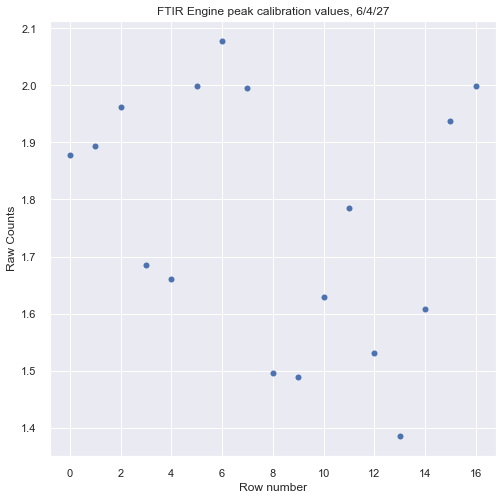

In [21]:
df = pd.read_csv('data/All_green_files_210604.csv')
vis_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        vis_cals.append((file_name, date, calibration[2:12], calibration[-6:]))

vis_cals_df = pd.DataFrame(data=vis_cals, columns=['file_name', 'date', 'session', 'calibration'])
today_df = vis_cals_df.loc[vis_cals_df['date'] == '6/4/21']

i_s = []
date_strs = []
white_values = []
for i in range(today_df.shape[0]):
    i_s.append(i)
    entire_path = path_name + today_df.iat[i, 0]
    cal_path = today_df.iat[i, 2] + "/" + today_df.iat[i, 3]
    date_str = vis_cals_df.iat[i, 1]
    
    try:
        with h5py.File(entire_path, 'r') as h5_file:
            spectrum = h5_file[cal_path].attrs['white_spectrum2'][:]
            waves = h5_file[cal_path].attrs['spec2_wavelengths_vector'][:]
    except:
        print("Exception thrown for ", date_str, cal_path)
                
    white_value = spectrum.max()    
    white_values.append(white_value)
    
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("FTIR Engine peak calibration values, 6/4/27")
ax.set_xlabel("Row number")
ax.set_ylabel("Raw Counts")
# ax.set_ylim(10000, 20000)
ax.plot(i_s, white_values, 'bo')

plt.show()
plt.close()

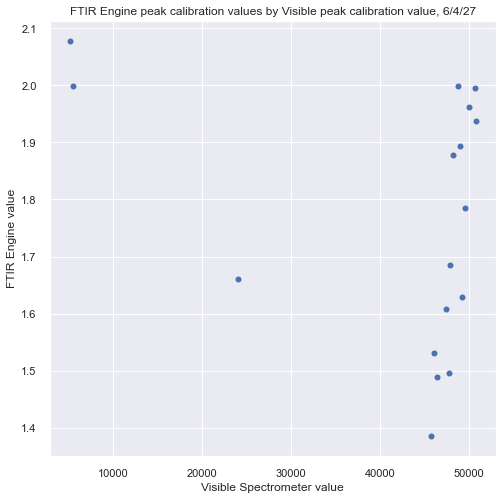

In [24]:
df = pd.read_csv('data/All_green_files_210604.csv')
vis_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        vis_cals.append((file_name, date, calibration[2:12], calibration[-6:]))

vis_cals_df = pd.DataFrame(data=vis_cals, columns=['file_name', 'date', 'session', 'calibration'])
today_df = vis_cals_df.loc[vis_cals_df['date'] == '6/4/21']

i_s = []
date_strs = []
white_values = []
ftir_white_values = []
for i in range(today_df.shape[0]):
    i_s.append(i)
    entire_path = path_name + today_df.iat[i, 0]
    cal_path = today_df.iat[i, 2] + "/" + today_df.iat[i, 3]
    date_str = vis_cals_df.iat[i, 1]
    
    try:
        with h5py.File(entire_path, 'r') as h5_file:
            spectrum = h5_file[cal_path].attrs['white_spectrum'][:]
            ftir_spectrum = h5_file[cal_path].attrs['white_spectrum2'][:]
            
    except:
        print("Exception thrown for ", date_str, cal_path)
                
    white_value = spectrum.max()
    ftir_white_value = ftir_spectrum.max()
    white_values.append(white_value)
    ftir_white_values.append(ftir_white_value)
    
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("FTIR Engine peak calibration values by Visible peak calibration value, 6/4/27")
ax.set_xlabel("Visible Spectrometer value")
ax.set_ylabel("FTIR Engine value")
# ax.set_ylim(10000, 20000)
ax.plot(white_values, ftir_white_values, 'bo')

plt.show()
plt.close()